# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [29]:
# Add any additional import statements you need here
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# change `data_location` to the location of the folder on your machine.
# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
data_location = "C:/Users/suemi/Downloads/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

In [3]:
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
artists = []
songs = [] 
lyrics = []

for item in os.listdir(data_location + lyrics_folder) : 
    if os.path.isdir(data_location + lyrics_folder + item) :
        for lyric_page in os.listdir(data_location + lyrics_folder + item) :
            artist,song = lyric_page.split("_")
            
            song = song.replace(".txt","")

            artists.append(artist)
            songs.append(song)
            
            with open(data_location + lyrics_folder + item + "/" + lyric_page) as infile : 
                next(infile) # skip title
                next(infile) # skip blank
                next(infile) # skip blank
                next(infile) # skip final blank
                
                lyrics.append(infile.read())
        

lyrics_data = pd.DataFrame()
lyrics_data['artist'] = artists
lyrics_data['song'] = songs
lyrics_data['lyrics'] = lyrics


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [20]:
# this is how I intially read the positive and negative data, into dataframes

positive_words = pd.read_csv('positive-words.txt', comment=';', header=None, names=['word'])
negative_words = pd.read_csv('negative-words.txt', comment=';', header=None, names=['word'])
tidytext = pd.read_csv('tidytext_sentiments.txt', delimiter='\t')

In [21]:
tidytext_df = tidytext
tidytext_df['sentiment'] = tidytext_df['sentiment'].replace({'positive': 1, 'negative': -1})
tidytext_df = pd.concat([positive_words.assign(sentiment=1), tidytext_df])
tidytext_df = pd.concat([negative_words.assign(sentiment=-1), tidytext_df])
tidytext_df = tidytext_df.drop_duplicates(subset='word')

tidytext_df.head(5)

,word,sentiment,lexicon
0,2-faced,-1,NaN
1,2-faces,-1,NaN
2,abnormal,-1,NaN
3,abolish,-1,NaN
4,abominable,-1,NaN


In [22]:
tidytext_df = tidytext_df.drop('lexicon', axis=1)
tidytext_df.head(5)

,word,sentiment
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1


In [ ]:
# then it was difficult to proceed with dataframes
# office hours helped with getting the data into a dictonary format

In [9]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sentiment = dict()

with open(positive_words_file, 'r') as infile :
    for idx, line in enumerate(infile.readlines()) :
        if line[0] == ";" :
            continue
            
        line = line.strip()
        
        if line and line.isalpha() :
            sentiment[line.strip()] = 1
            
with open(negative_words_file, 'r') as infile :
    for idx, line in enumerate(infile.readlines()) :
        if line[0] == ";" :
            continue
            
        line = line.strip()
        
        if line and line.isalpha() :
            sentiment[line.strip()] = -1
            
            
with open(tidy_text_file, 'r') as infile :
    next(infile)
    for line in infile.readlines() :
        word, sent, lexicon = line.strip().split("\t")
        
        if sent == "negative" :
            sentiment[word] = -1
        elif sent == "positive" :
            sentiment[word] = 1
        else :
            print(f"Got {word} with sentiment {sentiment}.")

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [10]:
def get_sentiment(text,sent=sentiment) :
    text = [w.lower() for w in text.split()]
    
    sentiment = sum([sent[word] for word in text if word in sent])
    
    return(sentiment)

In [11]:
lyrics_data['sentiment'] = lyrics_data['lyrics'].apply(get_sentiment)

In [12]:
average_sentiment = lyrics_data.groupby('artist')['sentiment'].mean()

average_sentiment

artist
cher     5.955696
robyn    7.644231
Name: sentiment, dtype: float64

In [13]:
first_artist = lyrics_data[lyrics_data['artist'] == 'cher']

sorted_by_sentiment = first_artist.sort_values(by='sentiment')

top_3_songs = sorted_by_sentiment.tail(3)
bottom_3_songs = sorted_by_sentiment.head(3)

In [14]:
top_3_songs

,artist,song,lyrics,sentiment
198,cher,perfection,"Hush little Baby, gotta be strong\n'Cause in t...",43
108,cher,ifoundyoulove,"Well I was looking for a new love, a different...",51
155,cher,loveandunderstanding,"Here, here in this world\nWhere do we go? Wher...",56


In [15]:
bottom_3_songs

,artist,song,lyrics,sentiment
16,cher,bangbang,Bang bang you shot me down\nBang bang I hit th...,-70
196,cher,outrageous,"Outrageous, outrageous\n(They say) I'm outrage...",-26
133,cher,iwalkonguildedsplinters,"Some people think they jive me, but I know the...",-24


In [23]:
# print lyrics
for i, row in top_3_songs.iterrows():
    print(row['lyrics'])
    print("-"*50)
    
print("-"*50)
print("-"*50)
print("-"*50)

for i, row in bottom_3_songs.iterrows():
    print(row['lyrics'])
    print("-"*50)

Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness inside stays the same

When love is here today, and th

In [24]:
second_artist = lyrics_data[lyrics_data['artist'] == 'robyn']

sorted_by_sentiment2 = second_artist.sort_values(by='sentiment')

top_3_songs1 = sorted_by_sentiment2.tail(3)
bottom_3_songs1 = sorted_by_sentiment2.head(3)

top_3_songs1

,artist,song,lyrics,sentiment
414,robyn,wedancetothebeat,We dance to the beat\nWe dance to the beat\nWe...,65
415,robyn,wedancetothebeat114528,We dance to the beat\nWe dance to the beat\nWe...,65
380,robyn,loveisfree,"Free\nLove is free, baby\nFree\nLove is free, ...",116


In [25]:
bottom_3_songs1

,artist,song,lyrics,sentiment
343,robyn,dontfuckingtellmewhattodo114520,My drinking is killing me\nMy drinking is kill...,-92
342,robyn,dontfuckingtellmewhattodo,My drinking is killing me\nMy drinking is kill...,-92
334,robyn,criminalintent,"Somebody alert the authorities, I got criminal...",-53


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The highest and lowest sentiment songs are shown above; obviously, some of the extreme words are seen in the song title and lyrics which maybe driving the scores.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The highest and lowest sentiment songs are shown above, and I think the it's for the same reason mentioned in the previous question.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




artist
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment, dtype: object

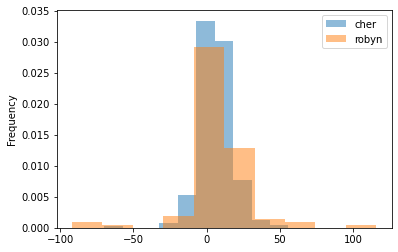

In [34]:
lyrics_data.groupby('artist')['sentiment'].plot(kind="hist",density=True,alpha=0.5,legend=True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [35]:
positive_emojis = ['😀','😃','😄','😁','😆','😊','😇','🙂','😍','🥰','😘','😗','😙','😚','😜']
negative_emojis = ['☹️','😣','😖','😫','😩','🥺','😢','😭','😒','😞','😟','😕','😠','😡','🤬']

emoji_sentiment = dict(zip(positive_emojis,[1]*15))
emoji_sentiment.update(dict(zip(negative_emojis,[-1]*15)))

emoji_sentiment

{'😀': 1,
 '😃': 1,
 '😄': 1,
 '😁': 1,
 '😆': 1,
 '😊': 1,
 '😇': 1,
 '🙂': 1,
 '😍': 1,
 '🥰': 1,
 '😘': 1,
 '😗': 1,
 '😙': 1,
 '😚': 1,
 '😜': 1,
 '☹️': -1,
 '😣': -1,
 '😖': -1,
 '😫': -1,
 '😩': -1,
 '🥺': -1,
 '😢': -1,
 '😭': -1,
 '😒': -1,
 '😞': -1,
 '😟': -1,
 '😕': -1,
 '😠': -1,
 '😡': -1,
 '🤬': -1}

In [45]:
def get_desc_sentiment(desc,sent=emoji_sentiment) :
    
    sentiment = sum([sent[ch] for ch in str(desc) if ch in sent])
    
    return(sentiment)

def extract_emojis(desc,emoji_list) :
    emojis = [ch for ch in str(desc) if ch in emoji_list]
    
    return(emojis)

In [46]:
twitter_data['sentiment'] = twitter_data.description.apply(get_desc_sentiment)
twitter_data['pos_emoji'] = twitter_data.description.apply(extract_emojis,args=(get_desc_sentiment == 1))
twitter_data['neg_emoji'] = twitter_data.description.apply(extract_emojis,args=(get_desc_sentiment == -1))

TypeError: extract_emojis() missing 1 required positional argument: 'emoji_list'

In [48]:
twitter_data.query('sentiment > 0').head()

,screen_name,name,id,location,followers_count,friends_count,description,artist,sentiment
110,KieraOsiecki,keezy,559655482,NaN,1229,623,welcome back 😚,cher,1
182,Mimijnm,Memi3,845613602,"Subn Chicago, USA",1383,3100,"Love my country, grandkids and dogs! (husband ...",cher,1
320,Good_Person_111,I stand with Ukraine 🇺🇦,1040097022307651589,"Illinois, USA",38,111,Stand with Ukraine 🇺🇦 Dan’s wife 🥰 Mollie’s mo...,cher,1
360,Sarah25Boussi,Sarah25,878738488061042689,NaN,0,262,😀,cher,1
471,VAAF07,Valentina,126409647,NaN,204,578,🏳️‍🌈 Berlina 😍,cher,1


In [47]:
twitter_data.query('sentiment < 0').head()

,screen_name,name,id,location,followers_count,friends_count,description,artist,sentiment
168,Mermarietho,Spoopy Jim 𓆏,722620867507724288,Crack House,54,266,"I just love my dog, man😭💖",cher,-1
1214,cyndeecexxx,cyndee cexxx,1502083138813575168,NaN,57,87,communist cum dumpster. here to be shared by t...,cher,-1
1543,RussellDeer1,Russell Deer,1399742498923233281,NaN,2,63,"🏳️‍🌈,💯🤬🤔🤗",cher,-1
1750,portraitxmirage,ari mirage 🎼 | i can’t be your only 1,1331255726468173827,the roof,1400,1356,just a small town girl tryna make it big🥺 || m...,cher,-1
1935,SABARBCHILE,👑 Nicki 🦄,1390926049610018816,"Cape Town, South Africa",789,1087,It's them weak bars thinkin' that she dissin' ...,cher,-1


In [49]:
twitter_data.groupby('artist').sentiment.mean()

artist
cher     0.008288
robyn    0.003187
Name: sentiment, dtype: float64

In [50]:
def get_top_n_emojis(emoji_list, n=3):
    emoji_count={}
    for emoji in emoji_list:
        if emoji in emoji_count:
            emoji_count[emoji] += 1
        else:
            emoji_count[emoji] = 1
    sorted_emojis = sorted(emoji_count.items(), key=lambda x: x[1], reverse=True)
    top_n_emojis = [emoji for emoji, count in sorted_emojis[:n]]
    return top_n_emojis

In [ ]:
# was unable to run this code due to not being able to extract 'pos_emoji' above
## emojis_by_artist = twitter_data.groupby('artist')['pos_emoji'].apply(lambda x: groupby(twitter_data['artist']))
## emojis_by_artist

Q: What is the average sentiment of your two artists? 

A: 0.008 and 0.003

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <

